In [1]:
import findspark
findspark.init('/home/tomokikyotani/spark-3.2.1-bin-hadoop3.2')
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [2]:
# Can only run this once. restart your kernel for any errors.
sc = SparkContext()

22/02/17 02:31:45 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 10.211.55.8 instead (on interface enp0s5)
22/02/17 02:31:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/17 02:31:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/02/17 02:31:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

/home/tomokikyotani/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
socket_stream = ssc.socketTextStream("127.0.0.1", 7755)

In [5]:
lines = socket_stream.window(20)

In [6]:
from collections import namedtuple
fields = ("tag", "count")
Tweet = namedtuple('Tweet', fields)

In [7]:
# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .limit(10).registerTempTable("tweets") ) ) # Registers to a table.

In [8]:
ssc.start()

22/02/17 02:31:51 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
22/02/17 02:31:51 WARN BlockManager: Block input-0-1645065111400 replicated to only 0 peer(s) instead of 1 peers


In [9]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline 

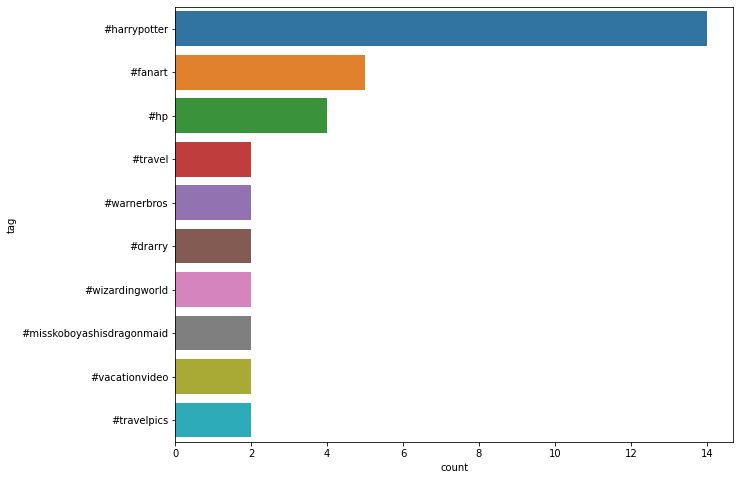

22/02/17 02:32:22 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
22/02/17 02:32:22 WARN BlockManager: Block input-0-1645065141800 replicated to only 0 peer(s) instead of 1 peers
ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/tomokikyotani/spark-3.2.1-bin-hadoop3.2/python/lib/py4j-0.10.9.3-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/tomokikyotani/spark-3.2.1-bin-hadoop3.2/python/lib/py4j-0.10.9.3-src.zip/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [11]:
count = 0
while count < 10:
    
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    plt.show()
    count = count + 1

In [ ]:
ssc.stop()